In [1]:
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.optim import Adam 


num_epochs = 5
num_classes = 10
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
K = 6000 # enter your length here
subsample_train_indices = torch.randperm(len(trainset))[:K]

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True, num_workers=2)#, sampler=subsample_train_indices)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=1000,
                                          shuffle=False, num_workers=2)

print(trainset)
print(testset)
print(len(train_loader.dataset))
print(len(test_loader.dataset))

100%|██████████| 170498071/170498071 [00:02<00:00, 75219998.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
50000
10000


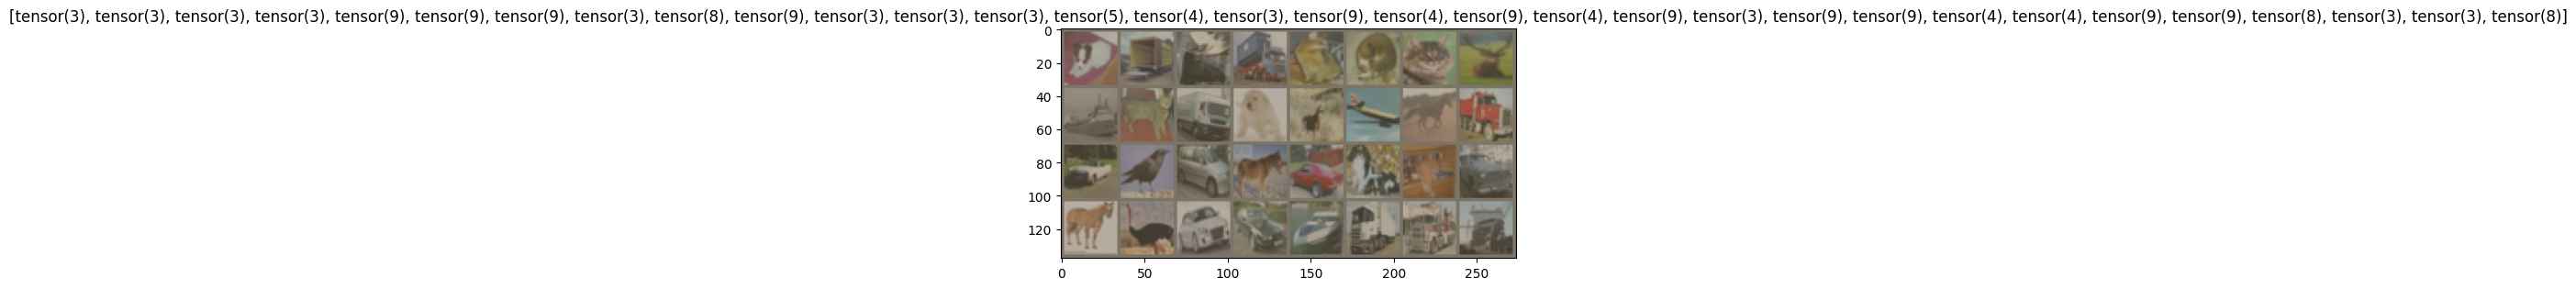

In [2]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes[x] for x in classes])

In [3]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x


def train_model(model, optimizer, criterion):
  tic = time.time()
  # Train the model
  total_step = len(train_loader)
  loss_list = []
  acc_list = []
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
  toc = time.time()
  return {'Training Loss':loss.item(), 'Training Accuracy':(correct / total), 'Training Time': toc-tic}

def test_model(model, test_loader):
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
      return (correct / total)




In [4]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()


In [5]:
accuracy=[]
training_loss=[]
training_time=[]
test_accuracy=[]

optimizer_list =['SGD', 'Adam', 'RMSprop']
for opt in optimizer_list:
    print('---------- {} ----------'.format(opt))
    model = CNN()
    if opt=='SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif opt=='Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif opt=='RMSprop':
      optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    train_res = train_model(model, optimizer, criterion )
    model.eval()
    test_res = test_model(model, test_loader)
    
    training_loss.append(train_res['Training Loss'])
    accuracy.append(train_res['Training Accuracy'])
    training_time.append(train_res['Training Time'])
    test_accuracy.append(test_res)

---------- SGD ----------
Epoch [1/5], Step [100/1563], Loss: 2.2734, Accuracy: 6.25%
Epoch [1/5], Step [200/1563], Loss: 2.2342, Accuracy: 18.75%
Epoch [1/5], Step [300/1563], Loss: 2.1864, Accuracy: 28.12%
Epoch [1/5], Step [400/1563], Loss: 2.1118, Accuracy: 18.75%
Epoch [1/5], Step [500/1563], Loss: 2.0770, Accuracy: 34.38%
Epoch [1/5], Step [600/1563], Loss: 2.0795, Accuracy: 21.88%
Epoch [1/5], Step [700/1563], Loss: 2.0369, Accuracy: 15.62%
Epoch [1/5], Step [800/1563], Loss: 1.9772, Accuracy: 31.25%
Epoch [1/5], Step [900/1563], Loss: 1.9558, Accuracy: 37.50%
Epoch [1/5], Step [1000/1563], Loss: 1.7981, Accuracy: 43.75%
Epoch [1/5], Step [1100/1563], Loss: 1.9196, Accuracy: 28.12%
Epoch [1/5], Step [1200/1563], Loss: 1.7829, Accuracy: 34.38%
Epoch [1/5], Step [1300/1563], Loss: 1.7715, Accuracy: 46.88%
Epoch [1/5], Step [1400/1563], Loss: 1.9211, Accuracy: 40.62%
Epoch [1/5], Step [1500/1563], Loss: 1.4855, Accuracy: 50.00%
Epoch [2/5], Step [100/1563], Loss: 1.8085, Accuracy: 

Text(0.5, 1.0, 'Training loss')

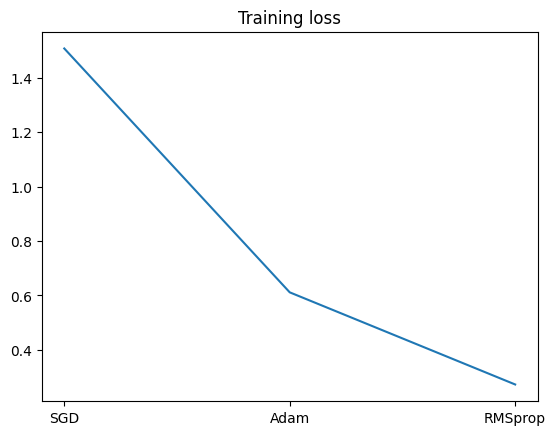

In [6]:
plt.plot(optimizer_list, training_loss)
plt.title('Training loss')

Text(0.5, 1.0, 'Training Accuracy')

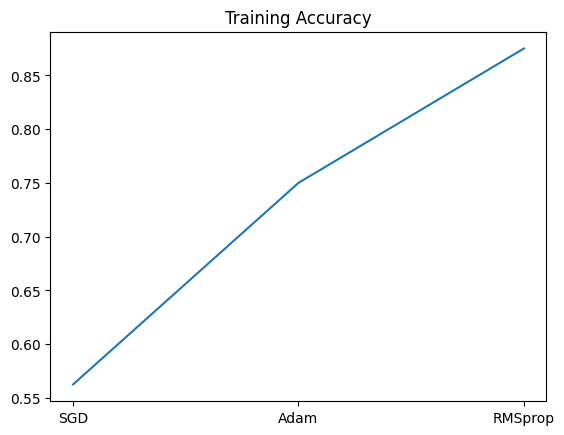

In [7]:
plt.plot(optimizer_list, accuracy)
plt.title('Training Accuracy')

Text(0, 0.5, 'Seconds (s)')

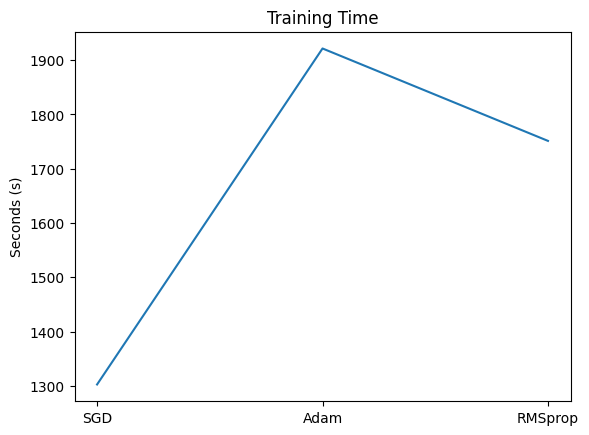

In [8]:
plt.plot(optimizer_list, training_time)
plt.title('Training Time')
plt.ylabel('Seconds (s)')

Text(0.5, 1.0, 'Test Accuracy')

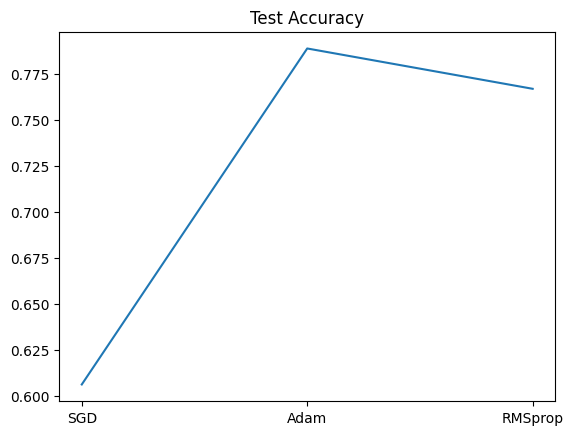

In [9]:
plt.plot(optimizer_list, test_accuracy)
plt.title('Test Accuracy')